### Import Libraries

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = ['Helvetica']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 14

### What is the ratio of toxic comments?

In [3]:
comments = pd.read_parquet('../data/comments.parquet')

In [4]:
print("Ratio of toxic comments:", sum(comments['openai_max_score']>=.5) / len(comments))

Ratio of toxic comments: 0.12433243242718107


### Read submissions file and get descriptive stats

In [6]:
df = pd.read_parquet('../data/submissions.parquet')

In [9]:
# keep only the test set for analysis
df = df[df['train_valid_test'] == 'test']

In [10]:
", ".join([f"{i} ({v})" for i,v in zip(df['subreddit'].value_counts().index, df['subreddit'].value_counts())])

'NoStupidQuestions (41954), antiwork (14979), politics (14257), worldnews (14143), WhitePeopleTwitter (10543), gaming (9500), AskUK (8854), Conservative (8561), Tinder (6692), relationship_advice (6392), movies (6349), mildlyinfuriating (6196), dating (4931), mildlyinteresting (4593), news (4049), aww (3682), RandomThoughts (3442), atheism (3103), personalfinance (2859), AskAnAmerican (2839), popculturechat (2834), Bitcoin (2571), Showerthoughts (2478), Music (2230), relationships (2100), technology (2078), nottheonion (1871), CasualConversation (1786), Frugal (1713), selfimprovement (1608), socialskills (1590), Jokes (1541), 4chan (1502), changemyview (1485), WTF (1427), RoastMe (1333), tifu (1186), science (1072), introvert (1025), 3amjokes (806), getdisciplined (769), MaliciousCompliance (617), HistoryPorn (513), UpliftingNews (490), sports (481), nosleep (435), GetMotivated (381), Liberal (225), AskEconomics (112), OutOfTheLoop (109)'

### What is the ratio of TA posts as a function of its toxic comments?

In [11]:
print("Ratio of toxic submissions:", sum(df['submission_openai']>=.5) / len(df))

Ratio of toxic submissions: 0.07584402134211184


In [12]:
print("Ratio of TA submissions:", sum(df['toxic_ratio']>0) / len(df))

Ratio of TA submissions: 0.5292390630923869


In [13]:
print("Ratio of TA but not T submissions:", sum((df['toxic_ratio']>0) & ~(df['submission_openai']>=.5)) / len(df))
sum((df['toxic_ratio']>0) & ~(df['submission_openai']>=.5))

Ratio of TA but not T submissions: 0.46855090019696144


101341

In [14]:
print("Ratio of TA and T submissions:", sum((df['toxic_ratio']>0) & (df['submission_openai']>=.5)) / len(df))
sum((df['toxic_ratio']>0) & (df['submission_openai']>=.5))

Ratio of TA and T submissions: 0.0606881628954255


13126

In [15]:
print("Ratio of T but not TA submissions:", sum(~(df['toxic_ratio']>0) & (df['submission_openai']>=.5)) / len(df))
sum(~(df['toxic_ratio']>0) & (df['submission_openai']>=.5))

Ratio of T but not TA submissions: 0.015155858446686332


3278

In [16]:
from matplotlib_venn import venn2

In [12]:
t_not_ta = sum(~(df['toxic_ratio']>0) & (df['submission_openai']>=.5)) / len(df)
ta_and_t = sum((df['toxic_ratio']>0) & (df['submission_openai']>=.5)) / len(df)
ta_not_t = sum((df['toxic_ratio']>0) & ~(df['submission_openai']>=.5)) / len(df)

In [13]:
coef = 1 / (ta_not_t + ta_and_t + t_not_ta)

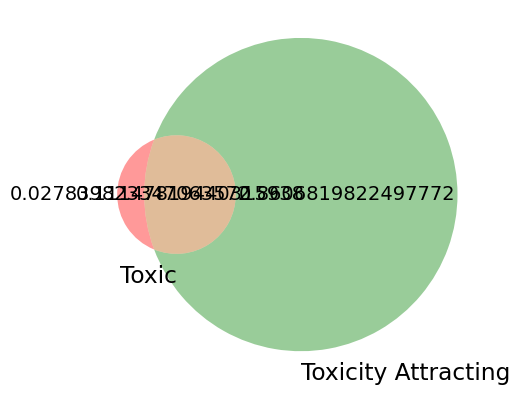

In [ ]:
venn2(subsets = (coef * t_not_ta, coef * ta_not_t, coef * ta_and_t), set_labels = ('Toxic', 'Toxicity Attracting'))
plt.savefig('../figures/venn_diagram.pdf', bbox_inches='tight')
plt.show()

In [15]:
toxic_filter = df['submission_openai']>=.5
toxic_ratio = sum(toxic_filter) / len(df)

In [16]:
ratio_analysis = []

for thresh in np.linspace(0, 1, 11)[1:]:
    ta_filter = df['toxic_ratio']>=thresh

    ratio_of_ta = sum(ta_filter) / len(df)
    ratio_of_ta_but_not_t = sum(ta_filter & ~toxic_filter) / len(df)
    ratio_of_ta_and_t = sum(ta_filter & toxic_filter) / len(df)
    ratio_of_t_but_not_ta = sum(~ta_filter & toxic_filter) / len(df)
    ratio_of_not_t_not_ta = sum(~ta_filter & ~toxic_filter) / len(df)
    
    ratio_analysis.append((thresh, ratio_of_ta, ratio_of_ta_but_not_t, ratio_of_ta_and_t, ratio_of_t_but_not_ta, ratio_of_not_t_not_ta))

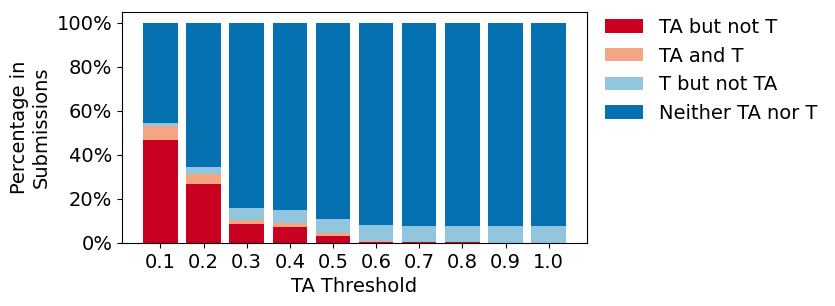

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3))

xticklabels = [str(round(i,2)) for i in np.linspace(0, 1, 11)[1:]]
bottom = np.array([0] * len(ratio_analysis))

for i, label, color in zip([2,3,4,5], ['TA but not T', 'TA and T', 'T but not TA', 'Neither TA nor T'], ['#ca0020', '#f4a582', '#92c5de', '#0571b0']):
    arr = np.array([x[i] for x in ratio_analysis])
    ax.bar(xticklabels, 
            arr*100,
            bottom = bottom,
            label=label,
            color=color)
    bottom = bottom + arr*100

ax.legend(frameon=False, bbox_to_anchor=(1, 1.05))
ax.set_xlabel('TA Threshold')
ax.set_ylabel('Percentage in\nSubmissions')
ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax.yaxis.set_major_formatter(ticker.PercentFormatter())

fig.savefig('../figures/ta_thresholding.pdf')
fig.show()

### Distribution of Real TA Scores

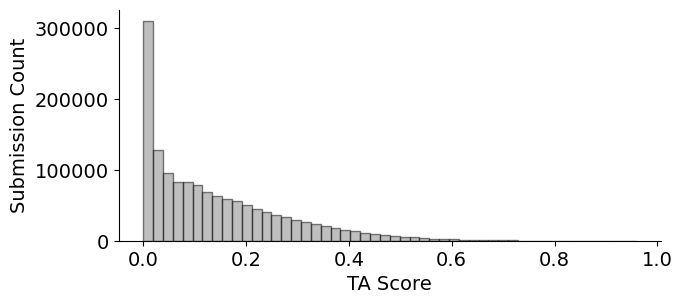

In [322]:
fig, ax = plt.subplots(figsize=(7, 3))
ax.hist(df['mean_openai'], bins=50, color='gray', alpha=0.5, edgecolor='black')

ax.set_xlabel('TA Score')
ax.set_ylabel('Submission Count')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig('../figures/ta_score_distribution.pdf')

fig.show()

### TA Model Performance

In [327]:
from sklearn.metrics import root_mean_squared_error
from scipy.stats import spearmanr

In [ ]:
root_mean_squared_error(df[df['train_valid_test']=='valid']['ta_score'], df[df['train_valid_test']=='valid']['mean_openai'])

0.09229026784792081

In [331]:
spearmanr(df[df['train_valid_test']=='valid']['ta_score'], df[df['train_valid_test']=='valid']['mean_openai'])

SignificanceResult(statistic=0.7399202045964561, pvalue=0.0)

In [ ]:
root_mean_squared_error(df[df['train_valid_test']=='test']['ta_score'],df[df['train_valid_test']=='test']['mean_openai'])

0.09975769157311579

In [332]:
spearmanr(df[df['train_valid_test']=='test']['ta_score'], df[df['train_valid_test']=='test']['mean_openai'])

SignificanceResult(statistic=0.7013369629960046, pvalue=0.0)